# ISIDORA

When a man rides a long time through wild regions he feels the desire for a city. Finally he comes to Isidora, a city where the buildings have spiral staircases encrusted with spiral seashells, where perfect telescopes and violins are made, where the foreigner hesitating between two women always encounters a third, where cockfights degenerate into bloody brawls among the bettors. He was thinking of all these things when he desired a city. Isidora, therefore, is the city of his dreams: with one difference. The dreamed-of city contained him as a young man; he arrives at Isidora in his old age. In the square there is the wall where the old men sit and watch the young go by; he is seated in a row with them. Desires are already memories.

In [2]:
from __future__ import print_function
from IPython.display import Image
%pylab inline

Populating the interactive namespace from numpy and matplotlib


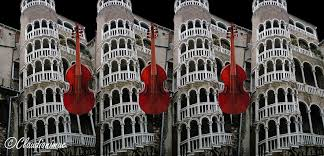

In [3]:
Image(filename='../Images/Isidora.jpg') 

In [4]:
import pandas as pd
import tables as tb
import numpy as np

In [5]:
from system_of_units import *

In [6]:
from PlotUtil import *
from Util import *

In [7]:
import logging
import sys
logger = logging.getLogger()
logger.handlers[0].stream = sys.stdout
logger.setLevel(logging.DEBUG)

In [8]:
import FEParam as FP
import SPE as SP
import FEE2 as FE

### BLR

#### Deconvolution function

In [9]:
from scipy import signal as SGN 

class SBLR:
    """
    Signals BLR: a simple class to hold of the signals relevant for BLR
    """
    def __init__(self, len_signal_daq):
        """
        len_signal_daq: length of the signal to deconvolute
        
        
        """
        
        self.MAU = np.zeros(len_signal_daq, dtype=np.double)
        self.acum = np.zeros(len_signal_daq, dtype=np.double)
        self.signal_r = np.zeros(len_signal_daq, dtype=np.double)
        self.pulse_on = np.zeros(len_signal_daq, dtype=np.double)
        self.wait_over = np.zeros(len_signal_daq, dtype=np.double)
        self.offset = np.zeros(len_signal_daq, dtype=np.double)
        self.BASELINE = 0
        

def BLR(signal_daq, coef, mau_len=250, thr1 = 3*FP.NOISE_ADC, thr2 = 0, 
        thr3 = FP.NOISE_ADC, log='INFO'):

    """
    Deconvolution offline of the DAQ signal using a MAU
    moving window-average filter of a vector data. See notebook 
    y(n) = (1/WindowSize)(x(n) + x(n-1) + ... + x(n-windowSize))
    in a filter operation filter(b,a,x):
    b = (1/WindowSize)*ones(WindowSize) = (1/WS)*[1,1,1,...]: numerator
    a = 1 : denominator
    y = filter(b,a,x)
    y[0] = b[0]*x[0] = (1/WS) * x[0]
    y[1] = (1/WS) * (x[0] + x[1])
    y[WS-1] = mean(x[0:WS])
    y[WS] = mean(x[1:WS+1])
    and so on
    """
    
    lg = 'logging.'+log
    logger.setLevel(eval(lg))
    len_signal_daq = len(signal_daq)
    sblr = SBLR(len_signal_daq)

    signal_i = np.copy(signal_daq) #uses to update MAU while procesing signal
    nm = mau_len
    B_MAU = (1./nm)*np.ones(nm)

#   MAU averages the signal in the initial tranch 
#    allows to compute the baseline of the signal  
    
    sblr.MAU[0:nm] = SGN.lfilter(B_MAU,1, signal_daq[0:nm])
    sblr.acum[nm] =  sblr.MAU[nm]
    sblr.BASELINE = sblr.MAU[nm-1]

    logging.debug("""-->BLR: 
                     MAU_LEN={}
                     thr1 = {}, thr2 = {}, thr3 = {} =""".format(
                     mau_len, thr1, thr2, thr3))
    logging.debug("n = {}, acum[n] = {} BASELINE ={}".format(nm, sblr.acum[nm],sblr.BASELINE))

#----------

# While MAU inits BLR is switched off, thus signal_r = signal_daq 

    sblr.signal_r[0:nm] = signal_daq[0:nm] 
    pulse_on=0
    wait_over=0
    offset = 0
    
    # MAU has computed the offset using nm samples
    # now loop until the end of DAQ window

    logging.debug("nm = {}".format(nm))
    
    for k in range(nm,len_signal_daq): 

        trigger_line = sblr.MAU[k-1] + thr1
        sblr.pulse_on[k] = pulse_on
        sblr.wait_over[k] = wait_over 
        sblr.offset[k] = offset
        
        # condition: raw signal raises above trigger line and 
        # we are not in the tail
        # (wait_over == 0)
        if signal_daq[k] > trigger_line and wait_over == 0:

            # if the pulse just started pulse_on = 0.
            # In this case compute the offset as value 
            #of the MAU before pulse starts (at k-1)

            if pulse_on == 0: # pulse just started
                #offset computed as the value of MAU before pulse starts
                offset = sblr.MAU[k-1]  
                pulse_on = 1 
                
            #Pulse is on: Freeze the MAU
            sblr.MAU[k] = sblr.MAU[k-1]  
            signal_i[k] = sblr.MAU[k-1]  #signal_i follows the MAU
            
            #update recovered signal, correcting by offset
            sblr.acum[k] = sblr.acum[k-1] + signal_daq[k] - offset;
            sblr.signal_r[k] = signal_daq[k] + coef*sblr.acum[k] 
                  
            
        else:  #no signal or raw signal has dropped below threshold
                      
        # but raw signal can be negative for a while and still contribute to the
        # reconstructed signal.

            if pulse_on == 1: #reconstructed signal still on
                # switch the pulse off only when recovered signal 
                #drops below threshold
                #slide the MAU, still frozen. 
                # keep recovering signal
                
                sblr.MAU[k] = sblr.MAU[k-1] 
                signal_i[k] = sblr.MAU[k-1]
                sblr.acum[k] = sblr.acum[k-1] + signal_daq[k] - offset;
                sblr.signal_r[k] = signal_daq[k] + coef*sblr.acum[k] 
                
                #if the recovered signal drops before trigger line 
                #rec pulse is over!
                if sblr.signal_r[k] < trigger_line + thr2:
                    wait_over = 1  #start tail compensation
                    pulse_on = 0   #recovered pulse is over
                      

            else:  #recovered signal has droped below trigger line
            #need to compensate the tail to avoid drifting due to erros in 
            #baseline calculatoin

                if wait_over == 1: #compensating pulse
                    # recovered signal and raw signal 
                    #must be equal within a threshold
                    # otherwise keep compensating pluse
                        
                    if signal_daq[k-1] < sblr.signal_r[k-1] - thr3:
                        # raw signal still below recovered signal 
                        # keep compensating pulse
                        # is the recovered signal near offset?
                        upper = offset + (thr3 + thr2)
                        lower = offset - (thr3 + thr2)
                        
                        if sblr.signal_r[k-1] > lower and sblr.signal_r[k-1] < upper:
                            # we are near offset, activate MAU. 
                            
                            signal_i[k] = sblr.signal_r[k-1]
                            sblr.MAU[k] = np.sum(signal_i[k-nm:k])*1./nm
                                      
                        else: 
                            # rec signal not near offset MAU frozen  
                            sblr.MAU[k] = sblr.MAU[k-1]
                            signal_i[k] = sblr.MAU[k-1]
                            
                        # keep adding recovered signal  
                        sblr.acum[k] = sblr.acum[k-1] + signal_daq[k] - sblr.MAU[k]
                        sblr.signal_r[k] = signal_daq[k] + coef*sblr.acum[k]
                        
                    else:  # raw signal above recovered signal: we are done 
                        
                        wait_over = 0
                        sblr.acum[k] = sblr.MAU[k-1]
                        sblr.signal_r[k] = signal_daq[k]
                        signal_i[k] = sblr.signal_r[k]
                        sblr.MAU[k] = np.sum(signal_i[k-nm:k])*1./nm
                        
                            
                else: #signal still not found
                    
                    #update MAU and signals
                    sblr.MAU[k] = np.sum(signal_i[k-nm:k]*1.)/nm   
                    sblr.acum[k] = sblr.MAU[k-1]
                    sblr.signal_r[k] = signal_daq[k]
                    signal_i[k] = sblr.signal_r[k]  
                                                                                                       
    #energy = np.dot(pulse_f,(signal_r-BASELINE)) 
    sblr.signal_r = sblr.signal_r - BASELINE     
    #return  signal_r-BASELINE, energy
    return  sblr


#### Helper functions

In [10]:
def accumulator_coefficients(pmtrd,CA):
    """
    Compute the accumulator coefficients for DBLR
    It computes the inverse function of the HPF and takes
    the accumulator as the value of the function anywhere
    but the first bin (the inverse is a step function with
    constant value equal to the accumulator)
    CA are the values of the capacitances defining the filter
    (1/(2CR)) for each PMT
    """
    len_WF = pmtrd.shape[2]
    NPMT = pmtrd.shape[1]
    
    coef_acc =np.zeros(NPMT, dtype=np.double)

    signal_t = np.arange(0.0, len_WF*1., 1., dtype=np.double)

    for j in range(NPMT):
        
        fee = FE.FEE(C=CA[j],R= FP.R, f=FP.freq_LPF, RG=FP.V_GAIN)
        signal_inv_daq = fee.InverseSignalDAQ(signal_t)  #inverse function
        coef_acc[j] = signal_inv_daq[10] #any index is valid, function is flat
        
    return coef_acc

def DBLR(pmtrd, event_number, coeff_acc, mau_len=250,
         thr1 = FP.NOISE_ADC, thr2=0, thr3 = FP.NOISE_ADC, log='INFO'):
    """
    Peform Base line Restoration
    coeff_acc is an array with the coefficients of the accumulator
    Threshold 1 is used to decide when raw signal raises up above trigger line
    Threshold 2 is used to decide when reconstructed signal is above trigger line
    Threshold 3 is used to compare Raw and Rec signal
    """
    
    len_WF = pmtrd.shape[2]
    NPMT = pmtrd.shape[1]
    
    BLRS =[]
    for j in range(NPMT):
        sblr = BLR(pmtrd[event_number, j], coeff_acc[j], mau_len, thr1, thr2, thr3, log)
        BLRS.append(sblr)
       
    return BLRS

#### Driver

In [11]:
import tables 

In [12]:
h5f = tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Na_test_RWF.h5', "r+")

In [13]:
pmtrwf = h5f.root.RD.pmtrwf

In [14]:
pmttwf = h5f.root.RD.pmttwf

In [15]:
epmt = h5f.root.RD.epmt

In [16]:
CA = FP.C12

In [17]:
CA/nF

array([ 6.02975448,  6.22547194,  6.0671337 ,  6.22159457,  6.29999787,
        6.09892384,  6.18289435,  6.21775591,  6.19306671,  6.30518792,
        6.20359891,  6.31231192])

In [18]:
coef = accumulator_coefficients(pmtrwf,CA)

In [19]:
coef

array([ 0.0017643 ,  0.00170883,  0.00175343,  0.0017099 ,  0.00168862,
        0.00174429,  0.0017206 ,  0.00171095,  0.00171778,  0.00168723,
        0.00171486,  0.00168533])

In [188]:
pmtrd = pmtrwf[0, 0] #WF for event = 0, PMT = 0

In [189]:
pmttw = pmttwf[0, 0] #WF for event = 0, PMT = 0

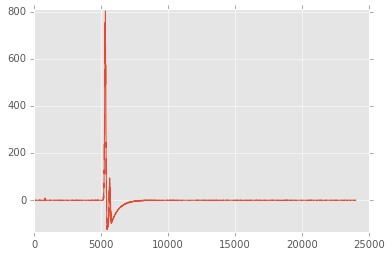

In [193]:
plts(pmtrd, signal_start=0, signal_end=25000, offset=10)

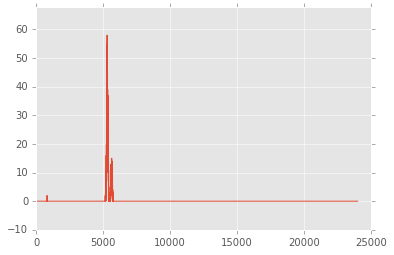

In [194]:
plts(pmttw, signal_start=0, signal_end=25000, offset=10)

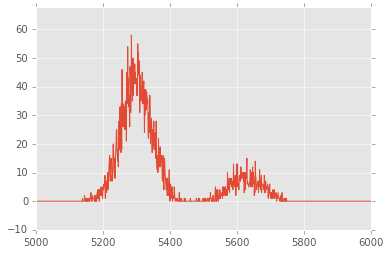

In [196]:
plts(pmttw, signal_start=5000, signal_end=6000, offset=10)

### Description of the BLR algorithm

1. The algorithm starts by computing the baseline, via a sliding MAU, which is initialized over the first few hundred samples.  

In [204]:
#sblr.MAU[0:nm] = SGN.lfilter(B_MAU,1, signal_daq[0:nm])
#sblr.acum[nm] =  sblr.MAU[nm]
#sblr.BASELINE = sblr.MAU[nm-1]

1. The algorithm starts by computing the baseline, via a sliding MAU, which is initialized over the first few hundred samples.
2. A trigger line is defined adding a threshold (thr1) to the baseline defined by the MAU. 

In [206]:
#for k in range(nm,len_signal_daq): 
#       trigger_line = sblr.MAU[k-1] + thr1

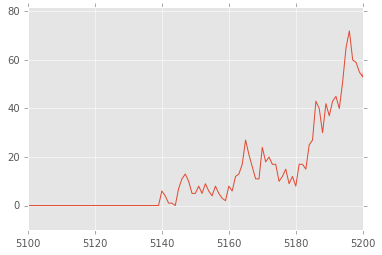

In [200]:
plts(pmtrd, signal_start=5100, signal_end=5200, offset=10)

thr1 can be set at a number of sigmas above the noise. One can see in the plot above that the signal is up at about 10 counts. The noise ADC corresponds to 2-3 counts, thus 3 x Noise appears reasonable. 

The raw signal then raises up and eventually swings to negative values, due to the HPF of the FEE.

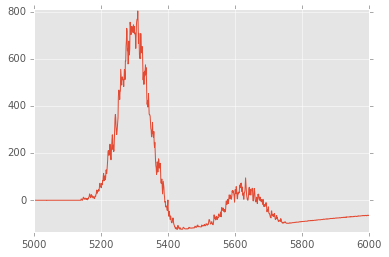

In [195]:
plts(pmtrd, signal_start=5000, signal_end=6000, offset=10)

The algorithm will raise the flag pulse_on = 1 when the *raw signal* goes above threshold and will continue recovering signal while the *reconstructed signal* is positive, that is above a trheshold defined by the trigger line (and an optinal additional threshold, thr2, which can be taken equal to zero for well behaved signals). 

Once the reconstructed signal drops below zero, the flag for pulse_on is set to zero, and a second flag, wait_over is set to one. Wait_over=1 while the raw_signal is below the reconstructed signal minus a threshold (thr3). Notice that the reconstructed signal is near zero, but one must continue accumulating while the raw signal is negative. The raw signal has often a long tail. 

In [ ]:
#if signal_daq[k-1] < sblr.signal_r[k-1] - thr3:

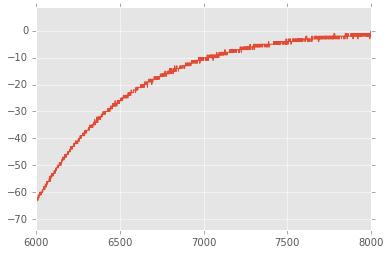

In [198]:
plts(pmtrd, signal_start=6000, signal_end=8000, offset=10)

In essence, the BLR algorithm will stop accumulating when the raw signal reaches zero. 

##### Examples

##### High thresholds

In [207]:
mau_len =250; thr1 = 20; thr2 = 0;  thr3 = 5; 

In [405]:
%time sbl = BLR(pmtrd, coef[0], mau_len, thr1, thr2, thr3, "DEBUG")

DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 20, thr2 = 0, thr3 = 5 =
DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =0.004
DEBUG:root:nm = 250
CPU times: user 256 ms, sys: 4.27 ms, total: 260 ms
Wall time: 269 ms


In [210]:
def plts(signal, signal_start=0, signal_end=1e+4, offset=5):

    ax1 = plt.subplot(1,1,1)
    ymin =np.amin(signal[signal_start:signal_end]) - offset
    ymax =np.amax(signal[signal_start:signal_end]) + offset
    ax1.set_xlim([signal_start, signal_end])
    ax1.set_ylim([ymin, ymax])
    plt.plot(signal)


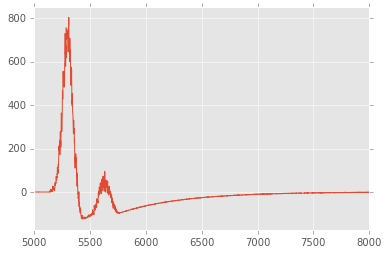

In [211]:
plts(pmtrd, signal_start=5000, signal_end=8000, offset=50)

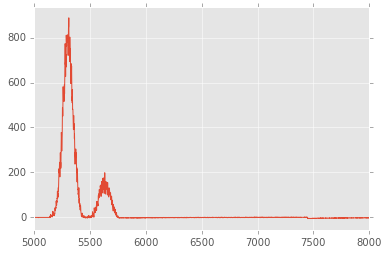

In [213]:
plts(sbl.signal_r, signal_start=5000, signal_end=8000, offset=50)

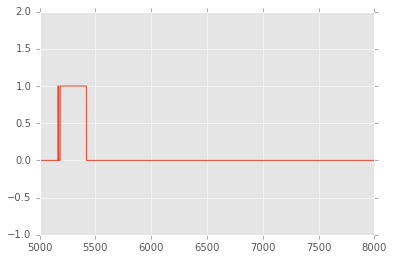

In [212]:
plts(sbl.pulse_on, signal_start=5000, signal_end=8000, offset=1)

##### NB: pulse_on =0 aroun 5400, but all the signal has not been recovered. The negative swing of the raw signal still will add a second pulse between 5400 and 5600 or so. wait over will switch on to 1. The algorithm has to keep track of whether the recovered signal is near zero (in which case the MAU is updated) or raises again, in which case the MAU is frozen. 

In [ ]:
#                     if signal_daq[k-1] < sblr.signal_r[k-1] - thr3:
#                         # raw signal still below recovered signal 
#                         # keep compensating pulse
#                         # is the recovered signal near offset?
#                         upper = offset + (thr3 + thr2)
#                         lower = offset - (thr3 + thr2)
                        
#                         if sblr.signal_r[k-1] > lower and sblr.signal_r[k-1] < upper:
#                             # we are near offset, activate MAU. 
                            
#                             signal_i[k] = sblr.signal_r[k-1]
#                             sblr.MAU[k] = np.sum(signal_i[k-nm:k])*1./nm
                                      
#                         else: 
#                             # rec signal not near offset MAU frozen  
#                             sblr.MAU[k] = sblr.MAU[k-1]
#                             signal_i[k] = sblr.MAU[k-1]
                            
#                         # keep adding recovered signal  
#                         sblr.acum[k] = sblr.acum[k-1] + signal_daq[k] - sblr.MAU[k]
#                         sblr.signal_r[k] = signal_daq[k] + coef*sblr.acum[k]
                        
#                     else:  # raw signal above recovered signal: we are done 
                        
#                         wait_over = 0
#                         sblr.acum[k] = sblr.MAU[k-1]
#                         sblr.signal_r[k] = signal_daq[k]
#                         signal_i[k] = sblr.signal_r[k]
#                         sblr.MAU[k] = np.sum(signal_i[k-nm:k])*1./nm

#### Wait over until raw signal near zero

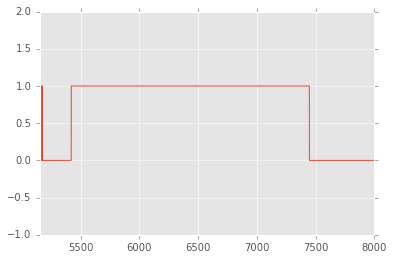

In [100]:
plts(sbl.wait_over, signal_start=5150, signal_end=8000, offset=1)

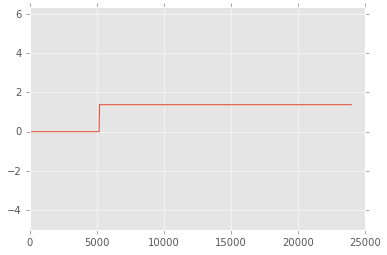

In [409]:
plts(sbl.offset, signal_start=0, signal_end=25000, offset=5)

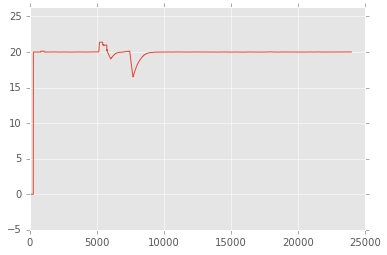

In [410]:
plts(sbl.trigger_line, signal_start=0, signal_end=25000, offset=5)

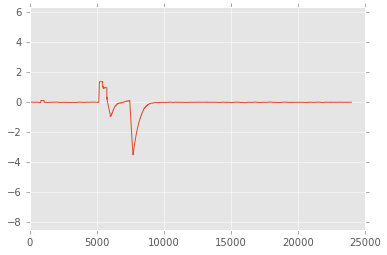

In [411]:
plts(sbl.MAU, signal_start=0, signal_end=25000, offset=5)

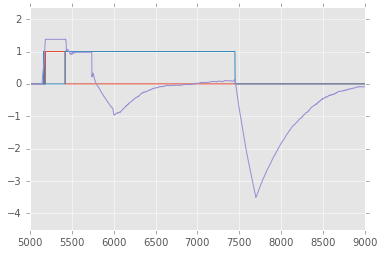

In [415]:
plts(sbl.pulse_on, signal_start=5000, signal_end=9000, offset=1)
plts(sbl.wait_over, signal_start=5000, signal_end=9000, offset=1)
plts(sbl.MAU, signal_start=5000, signal_end=9000, offset=1)

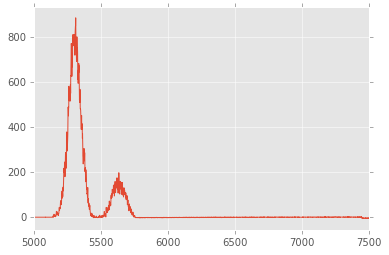

In [101]:
plts(sbl.signal_r, signal_start=5000, signal_end=7500, offset=50)

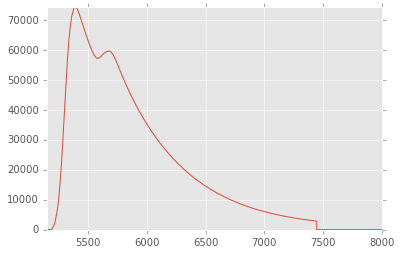

In [102]:
plts(sbl.acum, signal_start=5150, signal_end=8000, offset=50)

Notice the jump in the accumulator, near 7500. This is due to the thr3 being a bit too large

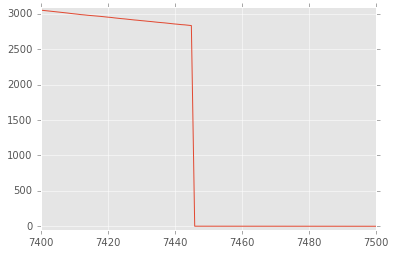

In [103]:
plts(sbl.acum, signal_start=7400, signal_end=7500, offset=50)

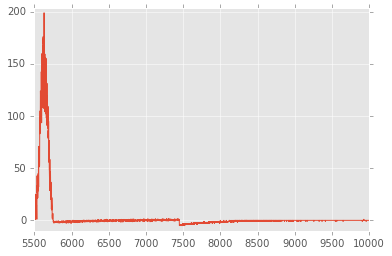

In [259]:
plts(sbl.signal_r, signal_start=5500, signal_end=10000, offset=5)

##### Notice the jump around 7500

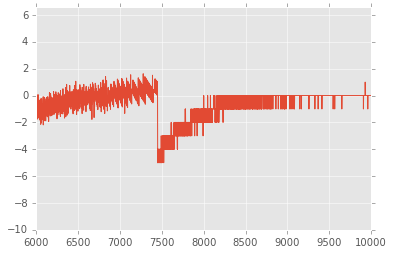

In [261]:
plts(sbl.signal_r, signal_start=6000, signal_end=10000, offset=5)

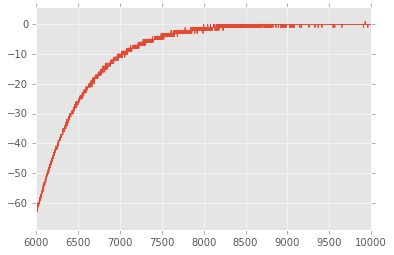

In [256]:
plts(pmtrd, signal_start=6000, signal_end=10000, offset=5)

##### The jump is due to a too high level for thr3 which introduces a discontinuity when the raw and recovered signals approach each other

In [214]:
epes = np.sum(pmttw)

In [216]:
erec = np.sum(sbl.signal_r)

In [215]:
epes

5925

In [217]:
erec

105913.65917228343

In [225]:
erec/epes

17.875723067052053

In [220]:
etmax = np.amax(pmttw)

In [221]:
ermax = np.amax(sbl.signal_r)

In [222]:
etmax

58

In [223]:
ermax

887.70536701758351

In [224]:
ermax/etmax

15.305264948579026

####  Low thresholds

In [262]:
%time sbl = BLR(pmtrd, coef[0], 250, 5, 0, 1, "DEBUG")

DEBUG:root:-->BLR: 
                     MAU_LEN=250
                     thr1 = 5, thr2 = 0, thr3 = 1 =
DEBUG:root:n = 250, acum[n] = 0.0 BASELINE =0.004
DEBUG:root:nm = 250
CPU times: user 255 ms, sys: 5.05 ms, total: 260 ms
Wall time: 274 ms


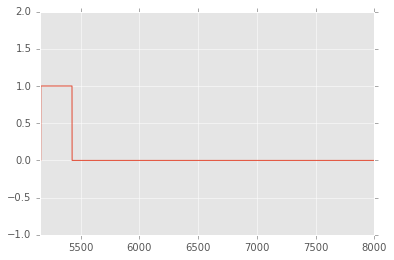

In [232]:
plts(sbl.pulse_on, signal_start=5150, signal_end=8000, offset=1)

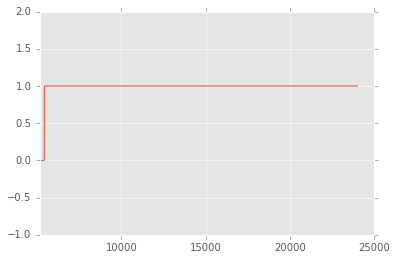

In [233]:
plts(sbl.wait_over, signal_start=5150, signal_end=25000, offset=1)

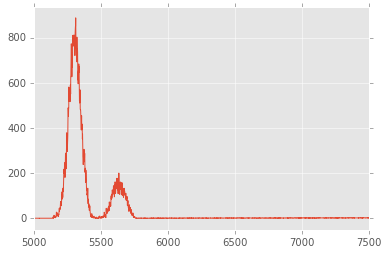

In [235]:
plts(sbl.signal_r, signal_start=5000, signal_end=7500, offset=50)

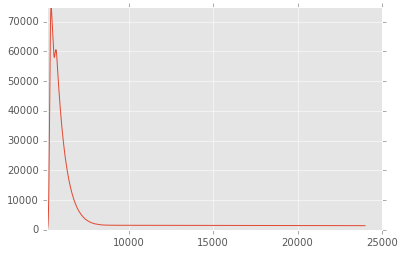

In [236]:
plts(sbl.acum, signal_start=5150, signal_end=25000, offset=50)

##### With a much lower threshold the accumulator ends up gracefully, but wait_over is always one, the raw and recovered signals never quite converge

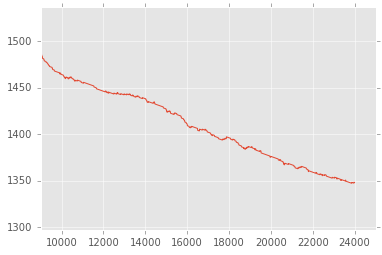

In [237]:
plts(sbl.acum, signal_start=9000, signal_end=25000, offset=50)

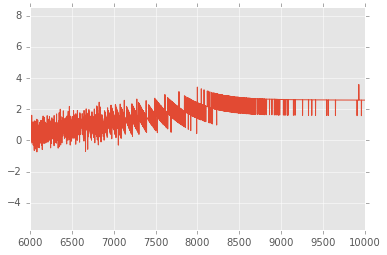

In [240]:
plts(sbl.signal_r, signal_start=6000, signal_end=10000, offset=5)

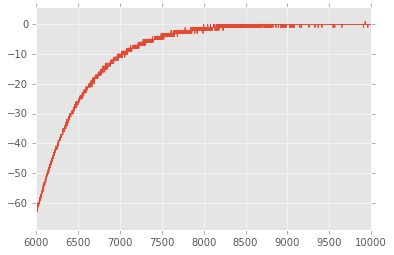

In [263]:
plts(pmtrd, signal_start=6000, signal_end=10000, offset=5)

In [242]:
erec = np.sum(sbl.signal_r)

In [243]:
erec

151261.15828081933

In [244]:
erec/epes

25.529309414484278

##### We recover almost 50 % more signal. This is clearly a fake, due to the fact that both signals oscilate around zero and we keep adding to the accumulator

### Using noise as criterium to set thresholds

##### Measured adc noise

In [118]:
FP.NOISE_ADC

1.792

In [416]:
%time sbl = BLR(pmtrd, coef[0], mau_len=250, thr1 = 3*FP.NOISE_ADC, thr2 = 0, thr3 = FP.NOISE_ADC, log='INFO')

CPU times: user 245 ms, sys: 5.39 ms, total: 250 ms
Wall time: 256 ms


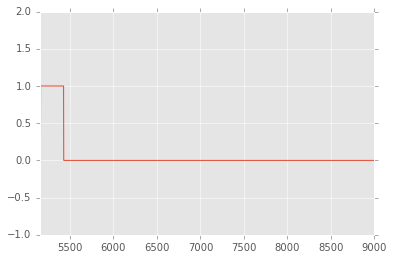

In [417]:
plts(sbl.pulse_on, signal_start=5150, signal_end=9000, offset=1)

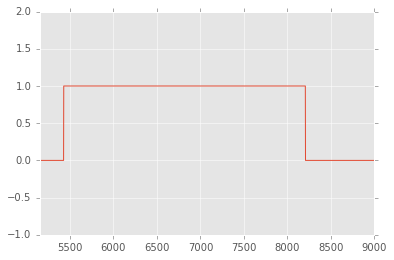

In [266]:
plts(sbl.wait_over, signal_start=5150, signal_end=9000, offset=1)

##### The signal ends now nicely. 

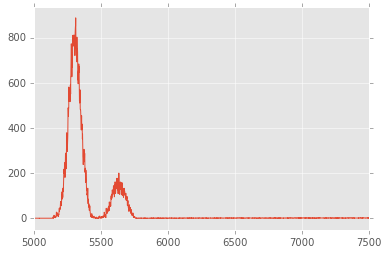

In [267]:
plts(sbl.signal_r, signal_start=5000, signal_end=7500, offset=50)

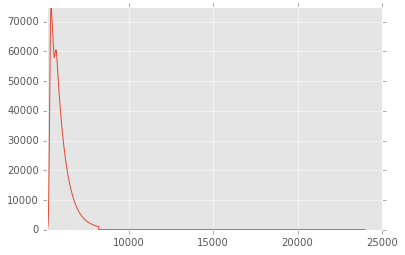

In [130]:
plts(sbl.acum, signal_start=5150, signal_end=25000, offset=50)

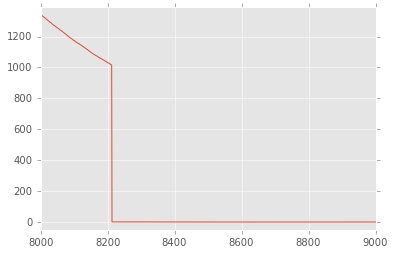

In [131]:
plts(sbl.acum, signal_start=8000, signal_end=9000, offset=50)

##### There is still a jump in the accumulator, but smaller

##### NB! getting wait_over to zero has a cost in the accumulator

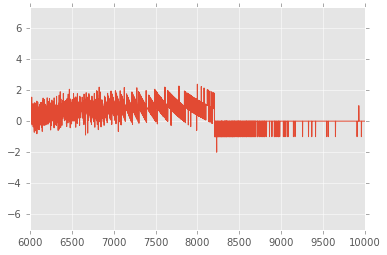

In [248]:
plts(sbl.signal_r, signal_start=6000, signal_end=10000, offset=5)

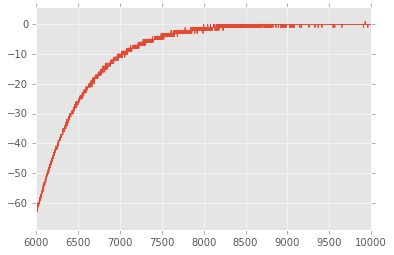

In [268]:
plts(pmtrd, signal_start=6000, signal_end=10000, offset=5)

##### But the recovered signal is flatter

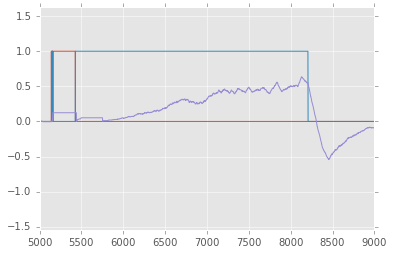

In [418]:
plts(sbl.pulse_on, signal_start=5000, signal_end=9000, offset=1)
plts(sbl.wait_over, signal_start=5000, signal_end=9000, offset=1)
plts(sbl.MAU, signal_start=5000, signal_end=9000, offset=1)

In [420]:
%time sbl = BLR(pmtrd, coef[0], mau_len=250, thr1 = 1*FP.NOISE_ADC, thr2 = 0, thr3 = FP.NOISE_ADC, log='INFO')

CPU times: user 250 ms, sys: 5.71 ms, total: 256 ms
Wall time: 261 ms


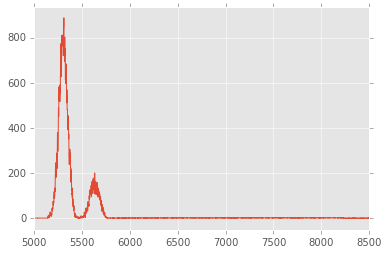

In [421]:
plts(sbl.signal_r, signal_start=5000, signal_end=8500, offset=50)

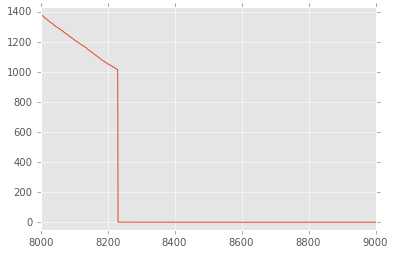

In [422]:
plts(sbl.acum, signal_start=8000, signal_end=9000, offset=50)

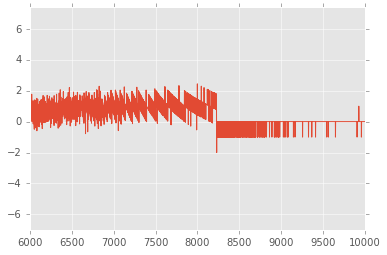

In [423]:
plts(sbl.signal_r, signal_start=6000, signal_end=10000, offset=5)

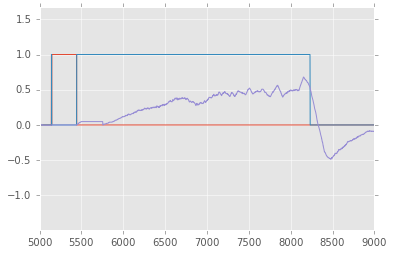

In [424]:
plts(sbl.pulse_on, signal_start=5000, signal_end=9000, offset=1)
plts(sbl.wait_over, signal_start=5000, signal_end=9000, offset=1)
plts(sbl.MAU, signal_start=5000, signal_end=9000, offset=1)

In [425]:
erec = np.sum(sbl.signal_r)

In [426]:
erec

111177.36284237432

In [427]:
erec/epes

18.764111872130687

In [428]:
emax = np.amax(sbl.signal_r)

In [429]:
emax

888.80993223145515

In [430]:
epsm = np.amax(pmttw)

In [431]:
epsm

58

In [433]:
emax/epsm

15.3243091764044

#### Fine tuning near threshold. 

When the recovered signal is near threshold, one can in principle use thr2 to fine-tue the algorithm, so that the MAU is updated near threshold, allowing for a better track of the baseline. 

In [275]:
%time sbl = BLR(pmtrd, coef[0], mau_len=250, thr1 = 3*FP.NOISE_ADC, thr2 = FP.NOISE_ADC, thr3 = FP.NOISE_ADC, log='INFO')

CPU times: user 291 ms, sys: 7.01 ms, total: 298 ms
Wall time: 309 ms


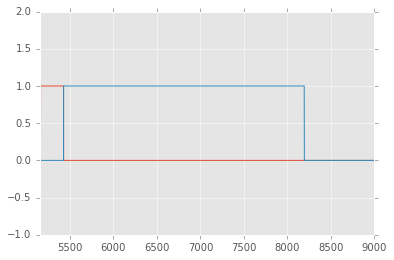

In [277]:
plts(sbl.pulse_on, signal_start=5150, signal_end=9000, offset=1)
plts(sbl.wait_over, signal_start=5150, signal_end=9000, offset=1)


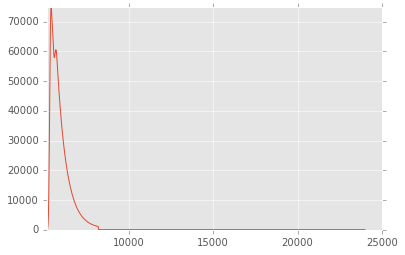

In [278]:
plts(sbl.acum, signal_start=5150, signal_end=25000, offset=50)


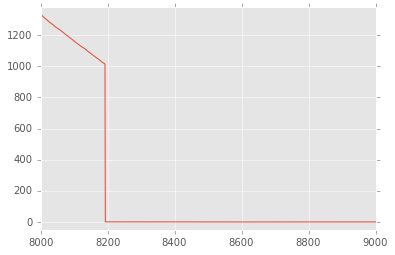

In [279]:
plts(sbl.acum, signal_start=8000, signal_end=9000, offset=50)


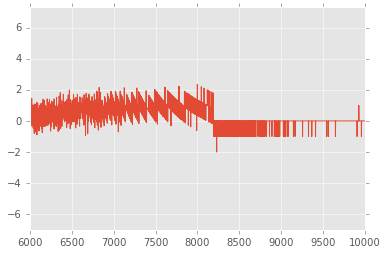

In [281]:
plts(sbl.signal_r, signal_start=6000, signal_end=10000, offset=5)

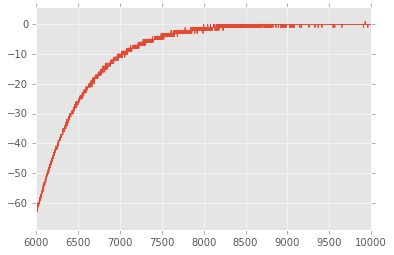

In [282]:
plts(pmtrd, signal_start=6000, signal_end=10000, offset=5)

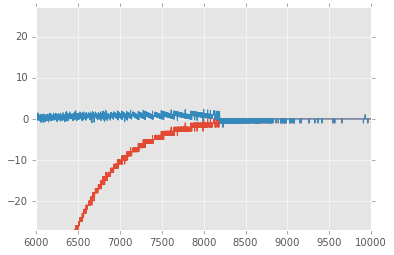

In [285]:
plts(pmtrd, signal_start=6000, signal_end=10000, offset=25)
plts(sbl.signal_r, signal_start=6000, signal_end=10000, offset=25)


#####  The effect of thr2 seems to be negligible. 

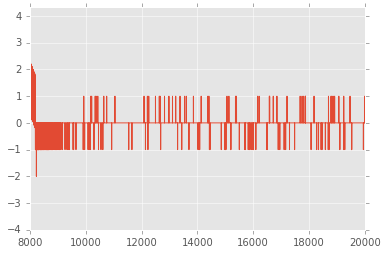

In [287]:
plts(sbl.signal_r, signal_start=8000, signal_end=20000, offset=2)

##### The recovered signal oscillates around zero, as it should be, adding the tail to the signal should be a net effect of near zero. We can study this by computing the energy of the signal while pulse_on =1 and wait_over = 1

In [288]:
erec = np.sum(sbl.signal_r)

In [289]:
erec

110549.91071799635

In [290]:
erec/epes

18.658212779408665

In [ ]:
#energy = np.dot(pulse_f,(signal_r-BASELINE)) 

##### First we recompute the energy subtracting the Baseline. 

In [291]:
erec = np.sum(sbl.signal_r - sbl.BASELINE)

In [292]:
erec

110453.91071799633

In [293]:
erec/epes

18.642010247763093

##### Now we require that pulse_on =1 or wait_over = 1

In [295]:
erec1 = np.dot(sbl.pulse_on, sbl.signal_r - sbl.BASELINE)

In [296]:
erec2 = np.dot(sbl.wait_over, sbl.signal_r - sbl.BASELINE)

In [297]:
erec = erec1 + erec2

In [298]:
erec1

90116.229601293366

In [299]:
erec2

20617.415079584352

In [300]:
erec

110733.64468087771

In [301]:
erec/epes

18.689222730949826

##### Notice that we recover a bit more of signal if we do not add the tail (slight negative swing)

### What is the dependence of the recovered signal with the value of thresholds? (number of sigmas)

In [307]:
def blr_mp(nsigma1=3,nsigma2=1):
    """
    A Marco Polo function to study the dependence of BLR with thresholds
    """
    sbl = BLR(pmtrd, coef[0], mau_len=250, thr1 = nsigma1*FP.NOISE_ADC, 
              thr2 = 0, thr3 = nsigma2*FP.NOISE_ADC, log='INFO')
    
    plts(sbl.pulse_on, signal_start=5150, signal_end=9000, offset=1)
    plts(sbl.wait_over, signal_start=5150, signal_end=9000, offset=1)
    plt.show()
    plts(sbl.acum, signal_start=5150, signal_end=25000, offset=50)
    plt.show()
    plts(sbl.acum, signal_start=8000, signal_end=9000, offset=50)
    plt.show()
    plts(sbl.signal_r, signal_start=5000, signal_end=9500, offset=50)
    plt.show()
    plts(sbl.signal_r, signal_start=6000, signal_end=10000, offset=5)
    plt.show()
    plts(sbl.signal_r, signal_start=8000, signal_end=20000, offset=2)
    plt.show()
    plts(pmtrd, signal_start=6000, signal_end=10000, offset=5)
    plt.show()
    plts(pmtrd, signal_start=8000, signal_end=20000, offset=5)
    plt.show()
    erec_a = np.sum(sbl.signal_r)
    erec_b = np.sum(sbl.signal_r - sbl.BASELINE)
    erec1 = np.dot(sbl.pulse_on, sbl.signal_r - sbl.BASELINE)
    erec2 = np.dot(sbl.wait_over, sbl.signal_r - sbl.BASELINE)
    erec_c = erec1 + erec2
    print("erec_a = {}, erec_b = {}, erec_c = {}".format(erec_a,erec_b,erec_c))
    print("erec_1 = {}, erec_2 = {}".format(erec1,erec2))
    
    


    
    

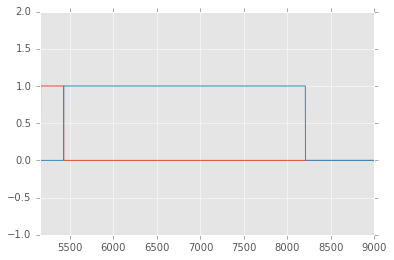

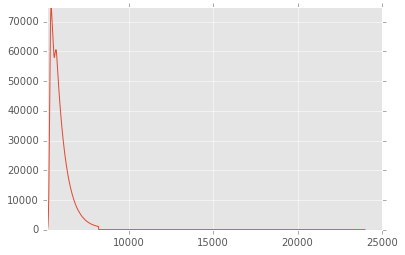

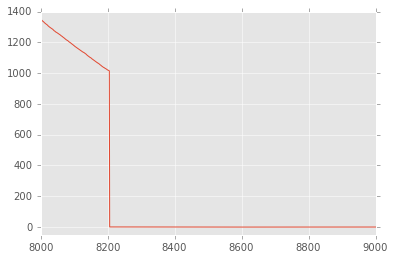

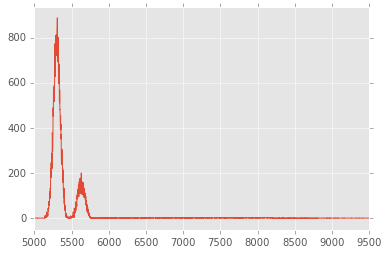

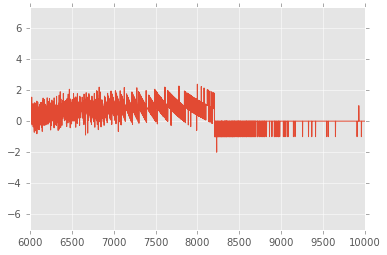

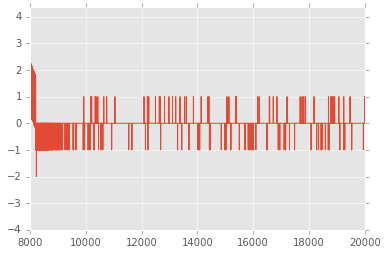

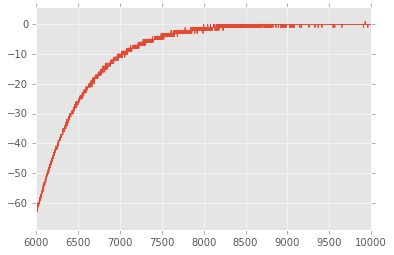

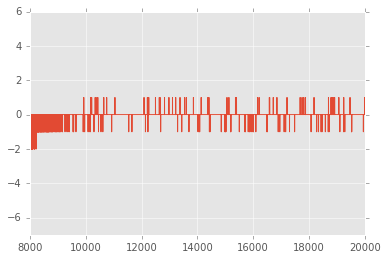

erec_a = 110708.761008, erec_b = 110612.761008, erec_c = 110882.442971
erec_1 = 90119.9803933, erec_2 = 20762.4625777


In [308]:
blr_mp(nsigma1=3,nsigma2=1)

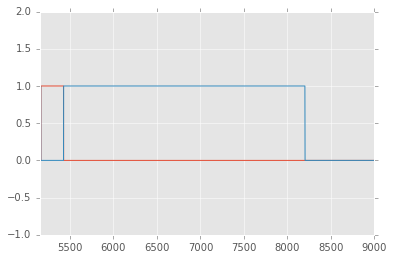

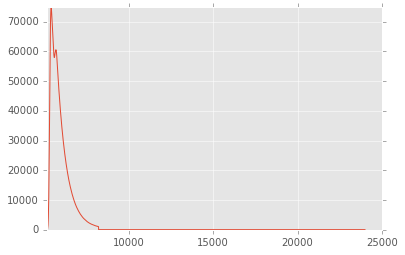

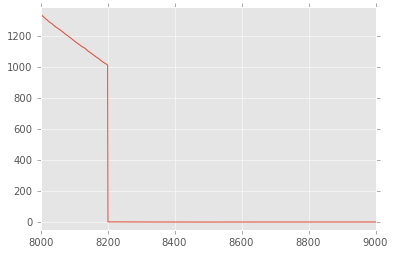

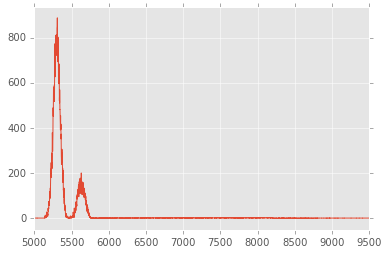

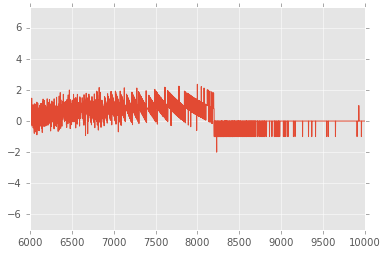

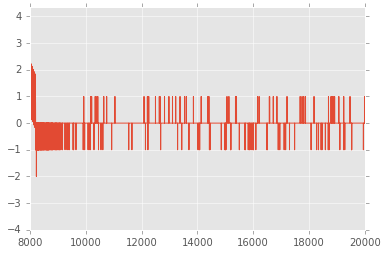

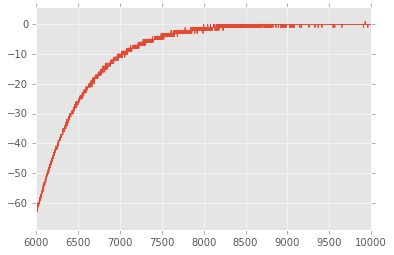

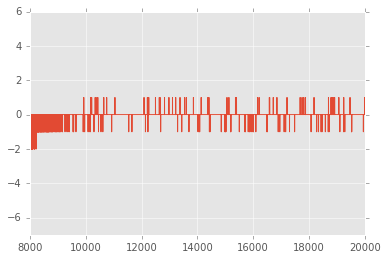

erec_a = 110563.662328, erec_b = 110467.662328, erec_c = 110695.360125
erec_1 = 90047.2330585, erec_2 = 20648.1270668


In [309]:
blr_mp(nsigma1=4,nsigma2=1)

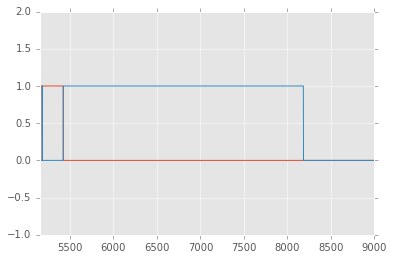

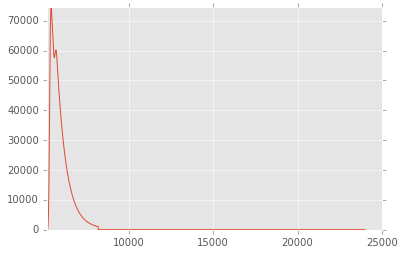

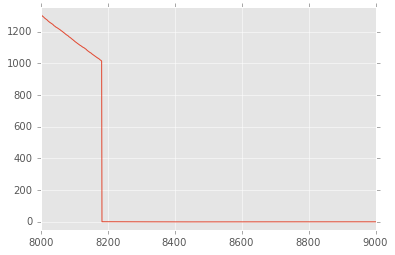

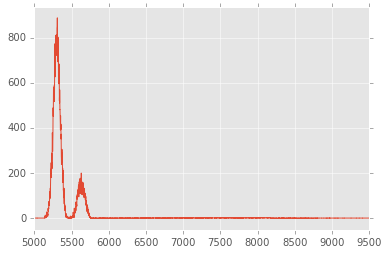

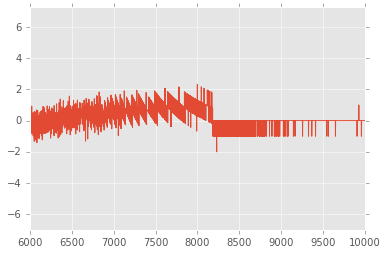

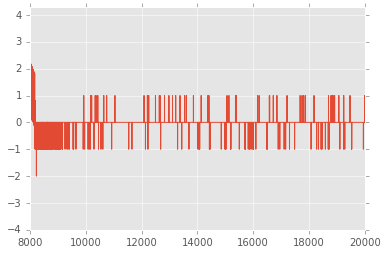

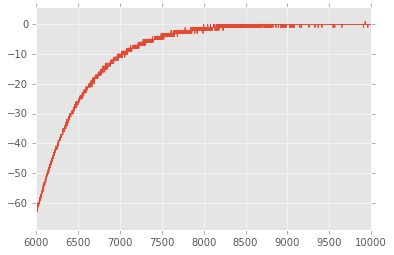

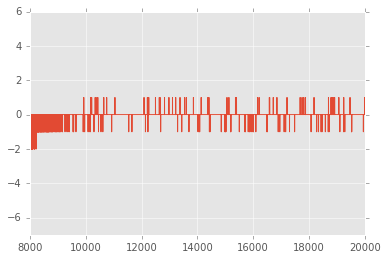

erec_a = 109495.846716, erec_b = 109399.846716, erec_c = 109598.6546
erec_1 = 89840.65019, erec_2 = 19758.0044098


In [310]:
blr_mp(nsigma1=5,nsigma2=1)

In [312]:
n_5_3 = 109598.6546/110882.442971

In [313]:
n_5_3

0.9884220771422239

##### changing the number of sigmas from 3 to 5 introduces a variation of 0.6 per mil. Thus the cut is robust

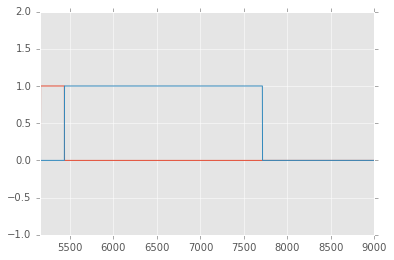

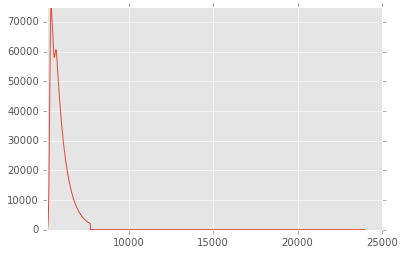

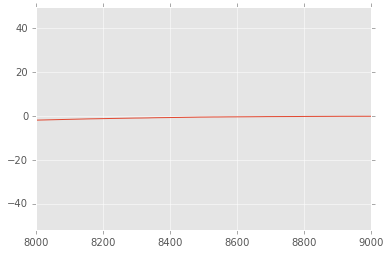

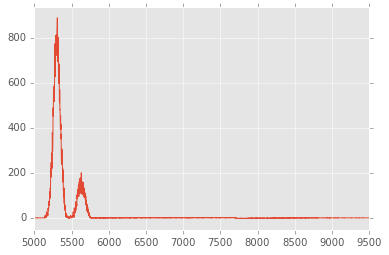

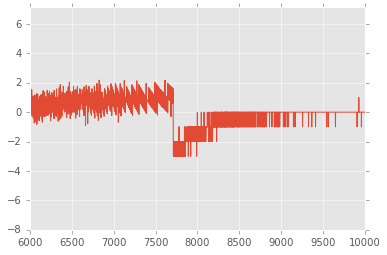

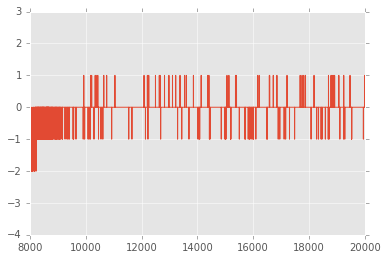

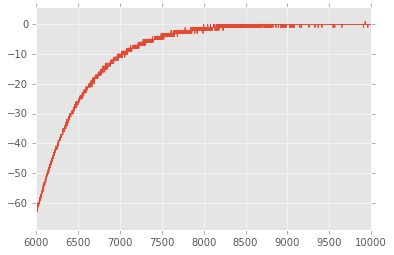

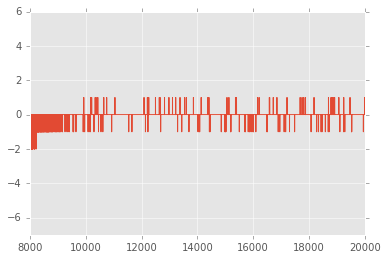

erec_a = 109425.504721, erec_b = 109329.504721, erec_c = 110403.159327
erec_1 = 90256.9443388, erec_2 = 20146.2149886


In [314]:
blr_mp(nsigma1=2,nsigma2=2)

In [315]:
n_3_3_2 = 110403.159327/110882.442971

In [316]:
n_3_3_2

0.9956775515477654

##### The variation is now 5 parts per mil and a clear discontinuity is seen. The threshold thr3 cannot be too high!

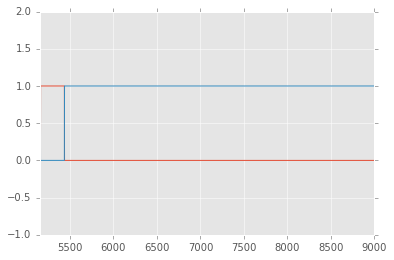

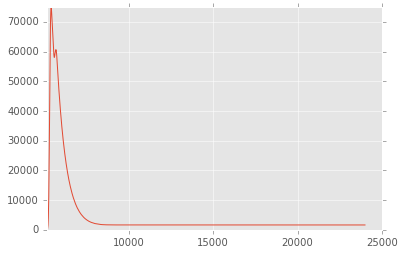

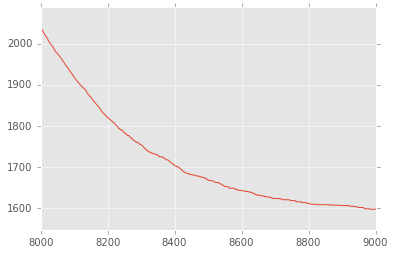

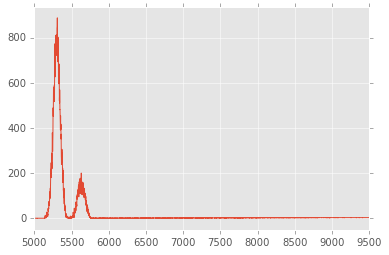

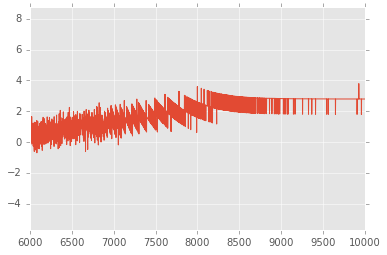

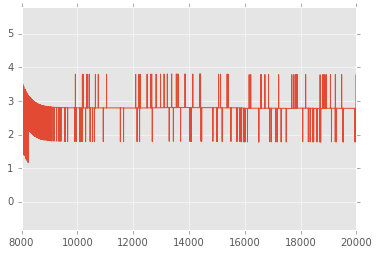

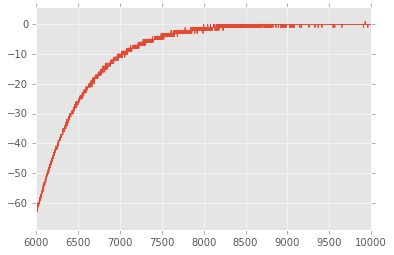

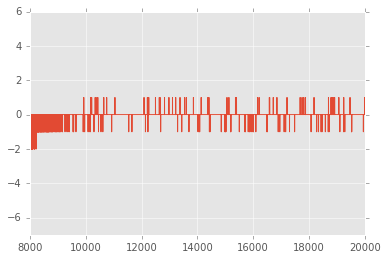

erec_a = 156217.566109, erec_b = 156121.566109, erec_c = 156116.072715
erec_1 = 90256.9443388, erec_2 = 65859.1283766


In [317]:
blr_mp(nsigma1=2,nsigma2=0.5)

##### Lowering the threshold too much implies that wait_over = 1 all the time and we keep accumulating even when the raw signal is near zero.

In [ ]:
plts(sbl.pulse_on, signal_start=5000, signal_end=9000, offset=1)
plts(sbl.wait_over, signal_start=5000, signal_end=9000, offset=1)
plts(sbl.MAU, signal_start=5000, signal_end=9000, offset=1)

#### IN CONCLUSION: the algo seems robust setting thr1 = 3 * sigma, thr2 = 0, thr3 = 1* sigma, where sigma is the rms of the noise. It also appears robust at thr1 = sigma, thr2 = sigma

### Looking at all PMTs in the event

In [327]:
def blr12(pmtrwf, epmt, coef, nsigma1 = 3, nsigma2 =1, event_number=0):
    """
    BLR algorithm for the 12 PMTs in the EP
    pmtrwf.shape = (nof_events, nof_sensors, wf_length)
    """
    NPMT = pmtrwf.shape[1]
    EREC=[]
    ER = []
    SBL =[]
    ETRUE = []
    E={}
    for i in range(NPMT):
        pmtrd = pmtrwf[event_number, i]
        sbl = BLR(pmtrd, coef[i], mau_len=250, thr1 = nsigma1*FP.NOISE_ADC, 
              thr2 = 0, thr3 = nsigma2*FP.NOISE_ADC, log='INFO')
        
        erec1 = np.dot(sbl.pulse_on, sbl.signal_r - sbl.BASELINE)
        erec2 = np.dot(sbl.wait_over, sbl.signal_r - sbl.BASELINE)
        erec = erec1 + erec2
        EREC.append(erec)
        ETRUE.append(epmt[event_number,i])
        ER.append(erec/epmt[event_number,i])
        SBL.append(sbl)
    E['etrue'] = ETRUE
    E['erec'] = EREC
    E['eratio'] = ER
    return pd.DataFrame(E), SBL
        

In [328]:
%time eDF, SBL = blr12(pmtrwf, epmt, coef, nsigma1 = 3, nsigma2 =1, event_number=0)

CPU times: user 3.2 s, sys: 21.8 ms, total: 3.22 s
Wall time: 3.24 s


In [329]:
eDF

,eratio,erec,etrue
0,18.714336,110882.442971,5925
1,18.681651,111641.543496,5976
2,18.550636,109541.505996,5905
3,18.736960,94677.860290,5053
4,18.833284,95315.248868,5061
5,18.820282,94571.919164,5025
6,18.733088,95669.878232,5107
7,18.761821,95685.287298,5100
8,18.742680,94706.762950,5053
9,18.736241,93999.720528,5017


In [330]:
eDF.describe()

,eratio,erec,etrue
count,12.000000,12.000000,12.000000
mean,18.733582,98987.068976,5284.916667
std,0.071212,7090.069689,393.629142
min,18.550636,93999.720528,5017.000000
25%,18.725296,94699.537285,5053.000000
50%,18.736601,95576.328959,5094.500000
75%,18.762129,99149.341973,5307.250000
max,18.833284,111641.543496,5976.000000


In [331]:
error = 0.07/18.7

In [332]:
error*1000.

3.7433155080213907

### Ratio between true and reconstructed energy in the PMTs 

The Ratio between true and reconstructed energy in the PMTs must be a good estimator of the uncertainties introduced by the BLR algorithm. For arbitrary events, the energy in each PMT is different (due to geometrical effects) but the ratio between true en reconstructed energy must be the same. For event zero we can see that the std of the ratio is 007, thus std/mean implies a relative error short of 4 per mil which appears acceptable. 

### Iterating over events

In [340]:
def blr_er(pmtrwf, epmt, coef, nsigma1 = 3, nsigma2 =1, first_event=0, last_event=10):
    """
    BLR algorithm for the 12 PMTs in the EP
    pmtrwf.shape = (nof_events, nof_sensors, wf_length)
    """
    NPMT = pmtrwf.shape[1]
    E={}
    for iev in range(first_event,last_event):
        ER = []
        for i in range(NPMT):
            pmtrd = pmtrwf[iev, i]
            sbl = BLR(pmtrd, coef[i], mau_len=250, thr1 = nsigma1*FP.NOISE_ADC, 
                      thr2 = 0, thr3 = nsigma2*FP.NOISE_ADC, log='INFO')
        
            erec1 = np.dot(sbl.pulse_on, sbl.signal_r - sbl.BASELINE)
            erec2 = np.dot(sbl.wait_over, sbl.signal_r - sbl.BASELINE)
            erec = erec1 + erec2
        
            ER.append(erec/epmt[iev,i])
        
        E[iev] = ER
   
    return pd.DataFrame(E)

In [341]:
%time edf = blr_er(pmtrwf, epmt, coef, nsigma1 = 3, nsigma2 =1, first_event=0, last_event=10)

CPU times: user 32.5 s, sys: 103 ms, total: 32.6 s
Wall time: 32.8 s


In [342]:
edf

,0,1,2,3,4,5,6,7,8,9
0,18.714336,18.830951,18.503341,18.369260,18.777410,16.686946,18.674347,18.545075,18.720541,18.585555
1,18.681651,18.823935,18.459826,18.776918,18.850006,14.882299,18.657008,18.506614,18.681704,18.677327
2,18.550636,18.857089,18.510482,18.353976,18.688702,13.504994,18.819397,18.558995,18.725367,18.652848
3,18.736960,18.847877,18.543368,18.671462,18.329873,17.457456,18.782138,18.430045,18.596024,18.637035
4,18.833284,18.917515,18.508428,18.590500,18.673955,16.257928,18.764599,18.479545,18.740868,18.730469
5,18.820282,18.939418,18.557086,18.493877,18.602213,14.754078,18.636328,18.537449,18.709080,18.574195
6,18.733088,18.854130,18.562498,18.303718,18.645823,16.177890,18.752188,18.448656,18.631728,18.699928
7,18.761821,18.937252,18.568496,18.567062,18.341718,15.152828,18.866699,18.442064,18.647597,18.751336
8,18.742680,18.942121,18.495068,18.611265,18.738992,16.358603,18.755103,18.458651,18.733982,18.685326
9,18.736241,18.820507,18.565769,18.255164,18.801397,15.019396,18.671316,18.488095,18.736440,18.632201


In [343]:
edf.describe()

,0,1,2,3,4,5,6,7,8,9
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
mean,18.733582,18.881774,18.525328,18.480118,18.651102,15.577845,18.754691,18.492759,18.660060,18.676965
std,0.071212,0.048849,0.036591,0.162839,0.162876,1.056859,0.083242,0.042364,0.121831,0.063435
min,18.550636,18.820507,18.459826,18.255164,18.329873,13.504994,18.636328,18.430045,18.301828,18.574195
25%,18.725296,18.843646,18.501273,18.356114,18.634920,14.985122,18.673590,18.456152,18.643630,18.635827
50%,18.736601,18.866928,18.526925,18.452631,18.681329,15.340859,18.759851,18.495073,18.702320,18.681326
75%,18.762129,18.934607,18.558439,18.595691,18.748597,16.283097,18.791452,18.521263,18.727521,18.721066
max,18.833284,18.942121,18.568496,18.776918,18.850006,17.457456,18.900213,18.558995,18.740868,18.779423


##### Notice that event = 5 has a lower ratio than all others. Let us examine this event in more detail

In [370]:
def blr12_mp(pmtrwf, epmt, coef, nsigma1 = 3, nsigma2 =1, event_number=5, pmt_number=0):
    """
    A Marco Polo function to examine events
    """
    eDF, SBL = blr12(pmtrwf, epmt, coef, nsigma1, nsigma2, event_number)
    return eDF, SBL
    
    #blr12_plt(eDF.ix[event_number],SBL[event_number],pmtrwf[event_number, pmt_number])

def blr12_plt(edf,sbl,pmtrd):
    """
    plot interesting stuff
    """
    plts(pmtrd, signal_start=0, signal_end=25000, offset=50)
    plt.show()
    plts(sbl.signal_r, signal_start=0, signal_end=25000, offset=50)
    plt.show()
    plts(sbl.pulse_on, signal_start=5150, signal_end=9000, offset=1)
    plt.show()
    plts(sbl.wait_over, signal_start=5150, signal_end=9000, offset=1)
    plt.show()
    plts(sbl.acum, signal_start=5150, signal_end=25000, offset=50)
    plt.show()
    plts(sbl.acum, signal_start=8000, signal_end=9000, offset=50)
    plt.show()
    plts(sbl.signal_r, signal_start=5000, signal_end=9500, offset=50)
    plt.show()
    plts(sbl.signal_r, signal_start=6000, signal_end=10000, offset=5)
    plt.show()
    plts(sbl.signal_r, signal_start=8000, signal_end=20000, offset=2)
    plt.show()
    plts(pmtrd, signal_start=6000, signal_end=10000, offset=5)
    plt.show()
    plts(pmtrd, signal_start=8000, signal_end=20000, offset=5)
    plt.show()
    erec_a = np.sum(sbl.signal_r)
    erec_b = np.sum(sbl.signal_r - sbl.BASELINE)
    erec1 = np.dot(sbl.pulse_on, sbl.signal_r - sbl.BASELINE)
    erec2 = np.dot(sbl.wait_over, sbl.signal_r - sbl.BASELINE)
    erec_c = erec1 + erec2
    print("erec_a = {}, erec_b = {}, erec_c = {}".format(erec_a,erec_b,erec_c))
    print("erec_1 = {}, erec_2 = {}".format(erec1,erec2))
    print("edf = {}".format(edf))
    

In [356]:
eDF, SBL = blr12_mp(pmtrwf, epmt, coef, nsigma1 = 3, nsigma2 =1, event_number=5, pmt_number=0)

In [357]:
event_number=5; pmt_number=0

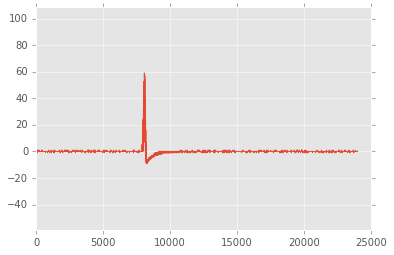

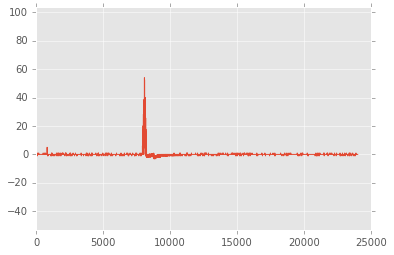

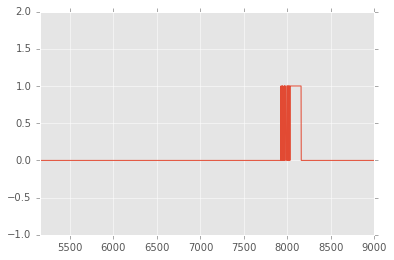

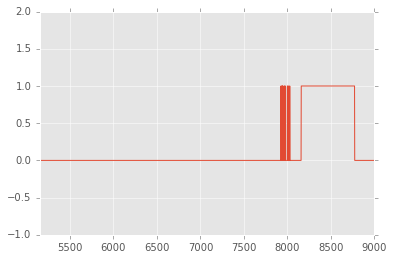

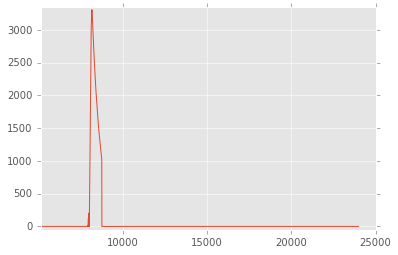

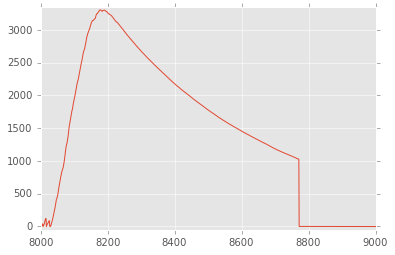

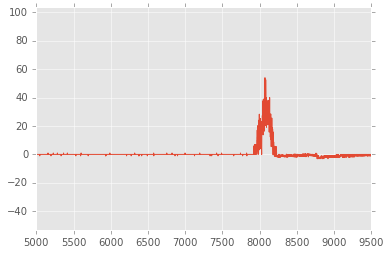

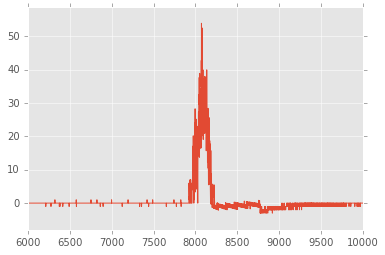

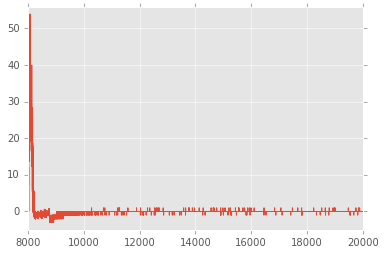

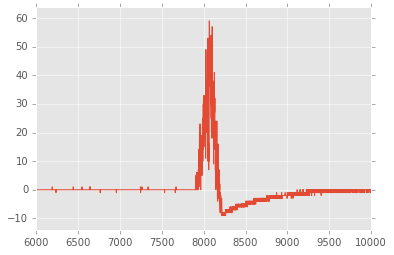

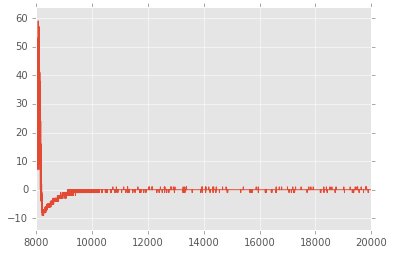

erec_a = 3487.11038217, erec_b = 3487.11038217, erec_c = 4145.89605759
erec_1 = 4107.53198495, erec_2 = 38.3640726391
edf = eratio      14.754078
erec      4145.896058
etrue      281.000000
Name: 5, dtype: float64


In [371]:
blr12_plt(eDF.ix[event_number],SBL[event_number],pmtrwf[event_number, pmt_number])

#####  The event is a very small signal. Study in detail

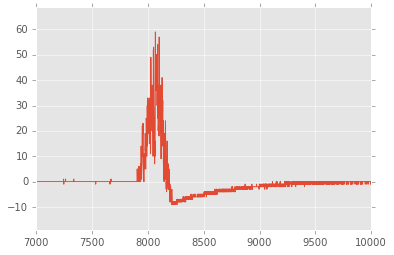

In [366]:
plts(pmtrwf[5, 0], signal_start=7000, signal_end=10000, offset=10)

In [361]:
sbl = SBL[0]

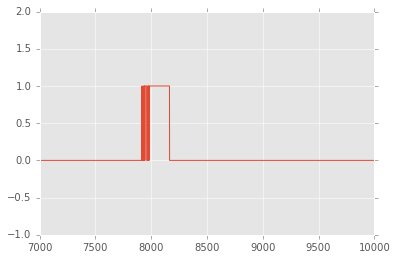

In [367]:
plts(sbl.pulse_on, signal_start=7000, signal_end=10000, offset=1)


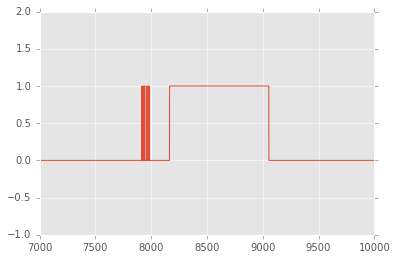

In [368]:
plts(sbl.wait_over, signal_start=7000, signal_end=10000, offset=1)

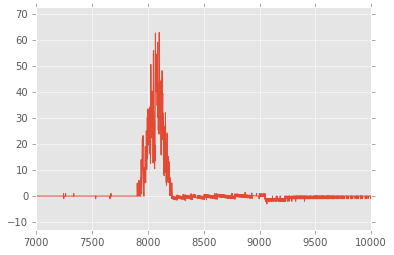

In [369]:
plts(sbl.signal_r, signal_start=7000, signal_end=10000, offset=10)

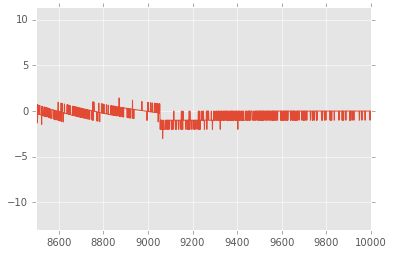

In [372]:
plts(sbl.signal_r, signal_start=8500, signal_end=10000, offset=10)

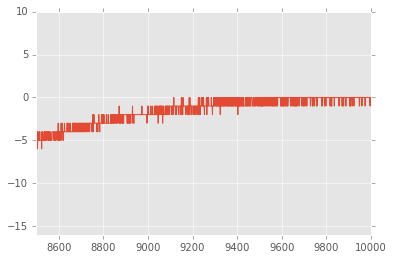

In [373]:
plts(pmtrwf[5, 0], signal_start=8500, signal_end=10000, offset=10)

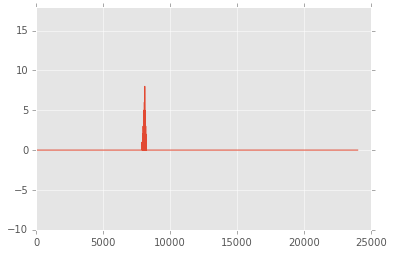

In [376]:
plts(pmttwf[5, 0], signal_start=0, signal_end=25000, offset=10)

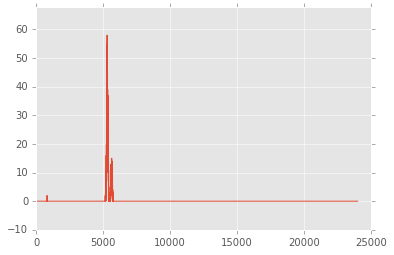

In [377]:
plts(pmttwf[0, 0], signal_start=0, signal_end=25000, offset=10)

In [379]:
epmt

/RD/epmt (EArray(10, 12), shuffle, blosc(9)) ''
  atom := Int32Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1365, 12)

In [380]:
epmt[5,0]

361

In [381]:
epmt[0,0]

5925

####  The algorithm appears to work well, but clearly the accuracy in the reconstruction depends on the intensity of the signal, for event 5 the true signal is about 20 times smaller than for event 0

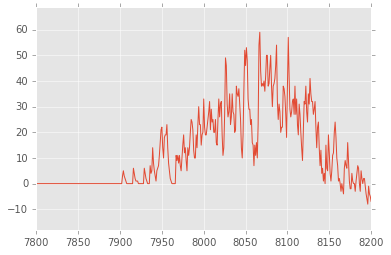

In [386]:
plts(pmtrwf[5, 0], signal_start=7800, signal_end=8200, offset=10)

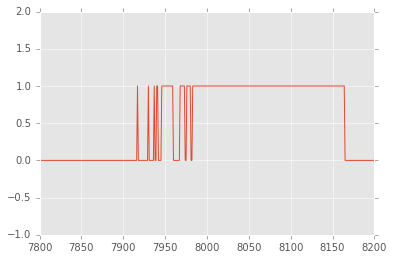

In [387]:
plts(sbl.pulse_on, signal_start=7800, signal_end=8200, offset=1)

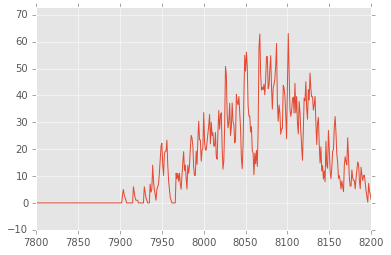

In [388]:
plts(sbl.signal_r, signal_start=7800, signal_end=8200, offset=10)

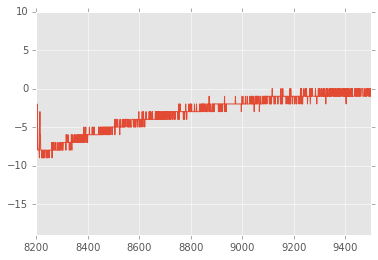

In [390]:
plts(pmtrwf[5, 0], signal_start=8200, signal_end=9500, offset=10)

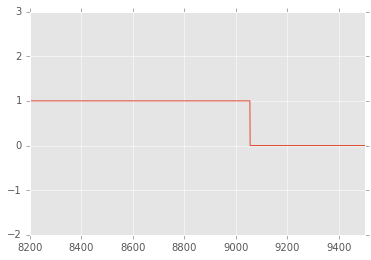

In [391]:
plts(sbl.wait_over, signal_start=8200, signal_end=9500, offset=2)

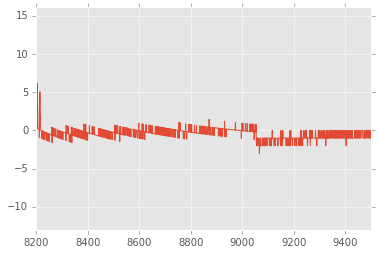

In [392]:
plts(sbl.signal_r, signal_start=8200, signal_end=9500, offset=10)

##### Signal appears perfectly recovered. Perhaps cutoff too high?

In [393]:
%time edf = blr_er(pmtrwf, epmt, coef, nsigma1 = 2, nsigma2 =1, first_event=0, last_event=10)

CPU times: user 36.4 s, sys: 285 ms, total: 36.7 s
Wall time: 37.6 s


In [394]:
edf

,0,1,2,3,4,5,6,7,8,9
0,18.743226,18.847066,18.519085,18.670429,18.818192,17.845896,18.834446,18.556936,18.731016,18.640495
1,18.784187,18.831191,18.549445,18.936864,18.910446,15.439914,18.681591,18.563054,18.750470,18.682268
2,18.563629,18.869898,18.521696,18.441379,18.734666,16.798389,18.854763,18.578120,18.748685,18.699757
3,18.751320,18.978881,18.549697,18.953546,18.832329,17.847266,18.802906,18.545422,18.633471,18.761224
4,18.857318,18.936657,18.529071,18.733281,18.718467,16.852319,18.841882,18.499160,18.763697,18.800451
5,18.823170,18.942828,18.571839,18.591123,18.649209,15.215032,18.702078,18.552088,18.733904,18.572527
6,18.751479,18.921882,18.593558,18.463980,18.705277,17.729146,18.826218,18.502501,18.701750,18.766367
7,18.760590,18.962064,18.619933,18.631453,18.844927,15.934391,18.924118,18.462395,18.678201,18.766386
8,18.767984,18.959168,18.532081,18.701177,18.795801,16.590688,18.878490,18.580662,18.752447,18.709190
9,18.742603,18.898135,18.579112,18.571283,18.831304,15.596498,18.823871,18.556453,18.766108,18.672048


In [395]:
edf.describe()

,0,1,2,3,4,5,6,7,8,9
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
mean,18.762829,18.915839,18.552241,18.650841,18.778210,16.658557,18.829738,18.538416,18.720684,18.716220
std,0.073077,0.047738,0.034630,0.162871,0.075748,0.931327,0.074316,0.035200,0.051777,0.067858
min,18.563629,18.831191,18.500050,18.441379,18.649209,15.215032,18.681591,18.462395,18.618584,18.572527
25%,18.749297,18.887761,18.527227,18.559503,18.715169,15.849918,18.818630,18.520366,18.695863,18.679713
50%,18.764287,18.929270,18.549571,18.611431,18.795786,16.825354,18.838164,18.548755,18.741295,18.717866
75%,18.793933,18.951230,18.573657,18.709203,18.831560,17.273941,18.868392,18.558466,18.755260,18.766372
max,18.857318,18.978881,18.619933,18.953546,18.910446,17.847266,18.924118,18.580662,18.769877,18.800451


In [419]:
%time edf = blr_er(pmtrwf, epmt, coef, nsigma1 = 1, nsigma2 =1, first_event=0, last_event=10)

CPU times: user 27.2 s, sys: 95.3 ms, total: 27.3 s
Wall time: 27.4 s


In [397]:
edf

,0,1,2,3,4,5,6,7,8,9
0,18.795772,18.893082,18.541548,18.720500,18.826183,17.887758,18.964838,18.561392,18.743102,18.688593
1,18.800969,18.907884,18.556807,18.967235,18.908325,18.882486,18.861787,18.563733,18.751083,18.686999
2,18.746795,18.887533,18.538317,18.772091,18.756826,18.551084,18.862642,18.580367,18.760635,18.737645
3,18.762356,18.982525,18.582454,19.002841,18.884469,17.963946,18.823698,18.547023,18.842383,18.779833
4,18.866973,19.015063,18.536208,19.158197,18.722161,18.900326,18.896997,18.525945,18.784447,18.870027
5,18.846617,18.968362,18.609450,18.724933,18.685412,15.476249,19.019329,18.552925,18.749082,18.622359
6,18.835889,18.929954,18.602119,18.728607,18.711254,19.566049,18.952867,18.574814,18.743048,18.785825
7,18.843939,18.960127,18.627860,18.884443,18.889592,17.321627,18.946083,18.557582,18.710170,18.775532
8,18.768129,18.967505,18.535400,18.731782,18.888632,19.221687,19.088968,18.585146,18.819821,18.728944
9,18.739361,18.922982,18.601649,18.655460,18.844869,15.762039,18.946882,18.576739,18.796607,18.760870


In [398]:
edf.describe()

,0,1,2,3,4,5,6,7,8,9
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
mean,18.802324,18.942131,18.570994,18.808886,18.819435,17.856726,18.942924,18.565999,18.767378,18.748622
std,0.042377,0.039391,0.033310,0.164295,0.080995,1.297223,0.075998,0.018507,0.052061,0.063584
min,18.739361,18.887533,18.535400,18.577138,18.685412,15.476249,18.823698,18.525945,18.667941,18.622359
25%,18.766685,18.909358,18.540740,18.723825,18.748160,17.240681,18.888408,18.556418,18.743088,18.718856
50%,18.798370,18.945040,18.567095,18.751936,18.835526,17.925852,18.946482,18.568709,18.755859,18.753820
75%,18.837902,18.967719,18.601767,18.905141,18.888872,18.886946,18.978460,18.577646,18.802411,18.781331
max,18.866973,19.015063,18.627860,19.158197,18.908325,19.566049,19.088968,18.592642,18.842383,18.870027


###  LOW CUTOFFs appear to be the best strategy!

In [435]:
import FEParam as FP

In [436]:
from scipy import signal as SGN

#### Inverse signal

In [440]:
len_WF = pmtrwf.shape[2]

In [441]:
signal_t = np.arange(0.0, len_WF*1., 1., dtype=np.double)

In [442]:
def inverse_signal(pmtrd_,signal_t, event_number,CA):
    """
    Peform Base line Restoration
    CA is an array with the values of the capacitances for the PMTs
    """
    import FEParam as FP
    import FEE2 as FE
    
    len_WF = pmtrd_.shape[2]
    NPMT = pmtrd_.shape[1]
    ene_pmt =np.zeros(len_WF, dtype=np.int32)
    
    inv = []
    for j in range(NPMT):
        pmtrd = pmtrd_[event_number, j] #waveform for event event_number, PMT j
        
        #Deconvolution
        fee = FE.FEE(C=CA[j],R= FP.R, f=FP.freq_LPF, RG=FP.V_GAIN)
        signal_inv_daq = fee.InverseSignalDAQ(signal_t)  #inverse function
        inv.append( signal_inv_daq)
    return pd.Series(inv)

In [443]:
idf = inverse_signal(pmtrwf,signal_t,event_number = 0, CA=FP.C12)

In [444]:
idf

0     [1.0008821504, 0.00176430079652, 0.00176430079...
1     [1.00085441719, 0.00170883437651, 0.0017088343...
2     [1.00087671552, 0.00175343104735, 0.0017534310...
3     [1.00085494967, 0.00170989934246, 0.0017098993...
4     [1.00084430984, 0.00168861968206, 0.0016886196...
5     [1.00087214571, 0.00174429142726, 0.0017442914...
6     [1.00086030101, 0.00172060201819, 0.0017206020...
7     [1.00085547749, 0.00171095498465, 0.0017109549...
8     [1.00085888793, 0.0017177758591, 0.00171777585...
9     [1.00084361486, 0.00168722971163, 0.0016872297...
10    [1.00085742975, 0.00171485949265, 0.0017148594...
11    [1.00084266276, 0.00168532552339, 0.0016853255...
dtype: object

In [445]:
def plot_inverse(wfdf):
    """
    plot the inverse function
    """
    
    plt.figure(figsize=(12,12))
    
    for i in range(12):
        wf = wfdf.ix[i]
        ax1 = plt.subplot(3,4,i+1)
        ax1.set_xlim([0, len(wf)])
        SetPlotLabels(xlabel='t (ns)', ylabel='adc')
        plt.plot(wf[1:])

    plt.show()

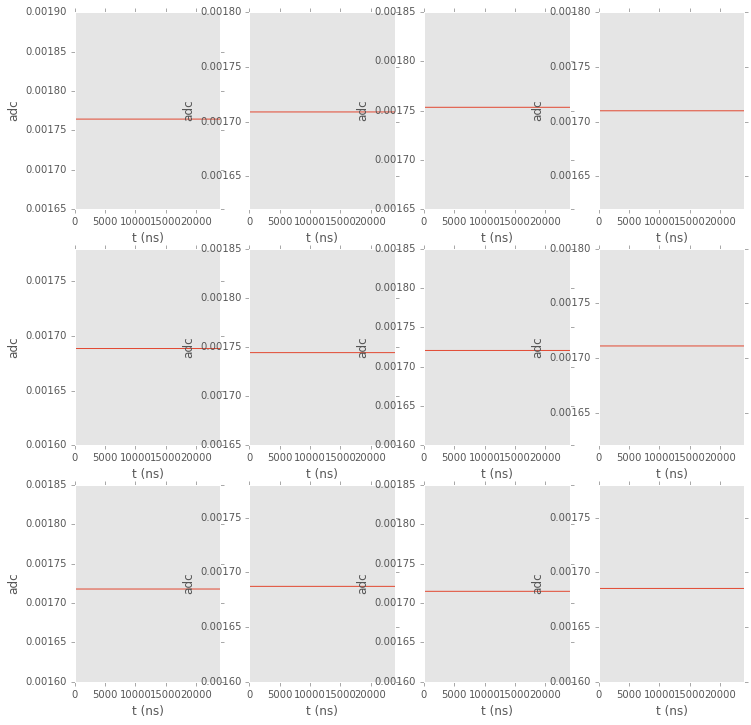

In [446]:
plot_inverse(idf)

### ISIDORA DRIVER

In [449]:
from Configure import configure

In [451]:
from cities import isidora

In [470]:
def ISIDORA(argv):
    INFO, CFP = configure(argv[0],argv[1:])
    if INFO:
        print(isidora)

    wait()
    
    print("""
        ISIDORA:
        1. Reads an Nh5 file produced by DIOMIRA, which stores the
            raw waveforms (RWF) for the PMTs and SiPMs waveforms, as well as
            data on geometry, sensors and MC. The RDWF of the PMTs
            show negative swing due to the HPF of the EP FEE electronics

        2. Performs DBLR on the PMT RWF and produces corrected waveforms (CWF).

        3. Adds the CWF and ancilliary info to the DST 

        4. Computes the energy of the PMTs per each event and writes to DST

        """)

    
    PATH_IN=CFP['PATH_IN'] 
    FILE_IN=CFP['FILE_IN']
    FIRST_EVT=CFP['FIRST_EVT']
    LAST_EVT=CFP['LAST_EVT']
    RUN_ALL=CFP['RUN_ALL']
    COEF=CFP['COEF']
    CA=farray_from_string(CFP['CA'])*nF 
    AC=farray_from_string(CFP['AC']) 
    MAU_LEN=CFP['MAU_LEN']
    NSIGMA1=CFP['NSIGMA1'] 
    NSIGMA2=CFP['NSIGMA2'] 

    NEVENTS = LAST_EVT -  FIRST_EVT


    logger.info("input path ={}; file_in ={} ".format(
        PATH_IN,FILE_IN))

    logger.info("first event = {} last event = {} nof events requested = {} ".format(
        FIRST_EVT,LAST_EVT,NEVENTS))

    logger.info("MAU length = {} n_sigma1 = {} n_sigma2 = {} ".format(
        MAU_LEN,NSIGMA1,NSIGMA2))
    logger.info("CA sigma(nf) = {}  ".format(CA/nF))
    

    # open the input file in mode append 
    with tables.open_file("{}/{}".format(PATH_IN,FILE_IN), "a") as h5in: 
        # access the PMT raw data in file 
        pmtrd_ = h5in.root.RD.pmtrwf

        #pmtrd_.shape = (nof_events, nof_sensors, wf_length)    
        
        NPMT = pmtrd_.shape[1]
        PMTWL = pmtrd_.shape[2] 
        NEVENTS_DST = pmtrd_.shape[0]

        logger.info("nof PMTs = {} nof events in input DST = {} ".format(
        NPMT,NEVENTS_DST))

        logger.info("lof PMT WF (MC) = {} ".format(
        PMTWL))

        wait()
            
        # create an extensible array to store the CWF waveforms
        # if it exists remove and create again
        pmtcwf =0
        try:
            pmtcwf = h5in.root.RD.pmtcwf
            h5in.remove_node("/RD","pmtcwf")
            pmtcwf = h5in.create_earray(h5in.root.RD, "pmtcwf", 
                                    atom=tables.FloatAtom(), 
                                    shape=(0, NPMT, PMTWL), 
                                    expectedrows=NEVENTS_DST)
        except tables.exceptions.NodeError:
            pmtcwf = h5in.create_earray(h5in.root.RD, "pmtcwf", 
                                    atom=tables.FloatAtom(), 
                                    shape=(0, NPMT, PMTWL), 
                                    expectedrows=NEVENTS_DST)

        # create a group to store BLR configuration (por PMT0)

        rgroup = 0
        try:
            rgroup = h5in.root.BLR
            
        except tables.exceptions.NodeError:
            rgroup = h5in.create_group(h5in.root, "BLR")

        
        MAU = 0
        acum = 0
        pulse_on = 0
        wait_over = 0

        try:
            mau = h5in.root.BLR.mau
            h5in.remove_node("/BLR","mau")
            mau = h5in.create_earray(h5in.root.BLR, "mau", 
                                    atom=tables.FloatAtom(), 
                                    shape=(0, PMTWL), 
                                    expectedrows=NEVENTS_DST)
        except tables.exceptions.NodeError:
            mau = h5in.create_earray(h5in.root.BLR, "mau", 
                                    atom=tables.FloatAtom(), 
                                    shape=(0, PMTWL), 
                                    expectedrows=NEVENTS_DST)
        try:
            pulse_on = h5in.root.BLR.pulse_on
            h5in.remove_node("/BLR","pulse_on")
            pulse_on = h5in.create_earray(h5in.root.BLR, "pulse_on", 
                                    atom=tables.IntAtom(), 
                                    shape=(0, PMTWL), 
                                    expectedrows=NEVENTS_DST)
        except tables.exceptions.NodeError:
            pulse_on = h5in.create_earray(h5in.root.BLR, "pulse_on", 
                                    atom=tables.IntAtom(), 
                                    shape=(0, PMTWL), 
                                    expectedrows=NEVENTS_DST)
        try:
            wait_over = h5in.root.BLR.wait_over
            h5in.remove_node("/BLR","wait_over")
            wait_over = h5in.create_earray(h5in.root.BLR, "wait_over", 
                                    atom=tables.IntAtom(), 
                                    shape=(0, PMTWL), 
                                    expectedrows=NEVENTS_DST)
        except tables.exceptions.NodeError:
            wait_over = h5in.create_earray(h5in.root.BLR, "wait_over", 
                                    atom=tables.IntAtom(), 
                                    shape=(0, PMTWL), 
                                    expectedrows=NEVENTS_DST)
        try:
            acum  = h5in.root.BLR.acum 
            h5in.remove_node("/BLR","acum")
            acum  = h5in.create_earray(h5in.root.BLR, "acum", 
                                    atom=tables.FloatAtom(), 
                                    shape=(0, PMTWL), 
                                    expectedrows=NEVENTS_DST)
        except tables.exceptions.NodeError:
            acum  = h5in.create_earray(h5in.root.BLR, "acum", 
                                    atom=tables.FloatAtom(), 
                                    shape=(0, PMTWL), 
                                    expectedrows=NEVENTS_DST)

            
        if NEVENTS > NEVENTS_DST and RUN_ALL == False:
            print("""
                Refusing to run: you have requested
                FIRST_EVT = {}
                LAST_EVT  = {}
                Thus you want to run over {} events
                but the size of the DST is {} events.
                Please change your choice or select RUN_ALL = TRUE
                to run over the whole DST when this happens
                """.format(FIRST_EVT,LAST_EVT,NEVENTS,NEVENTS_DST))
            sys.exit(0)

        elif  NEVENTS > NEVENTS_DST and RUN_ALL == True:
            FIRST_EVT = 0
            LAST_EVT = NEVENTS_DST
            NEVENTS = NEVENTS_DST

            
        for i in range(FIRST_EVT,LAST_EVT):
            
            logger.info("-->event number ={}".format(i))

            #DBLR
            coeff_acc = AC
            if COEF == 0:
                coeff_acc = accumulator_coefficients(pmtrd_,CA)


            BLRS = DBLR(pmtrd_, i, coeff_acc, mau_len=MAU_LEN,
                        thr1 = NSIGMA1*FP.NOISE_ADC, thr2=0, 
                        thr3 = NSIGMA2*FP.NOISE_ADC, log='INFO')

            
            pmtCWF = []
            for blr in BLRS:
                pmtCWF.append(blr.signal_r)
                
            #append to pmtcwd
            pmtcwf.append(np.array(pmtCWF).reshape(1, NPMT, PMTWL))

            # append BLR variables

            mau_pmt0 = BLRS[0].MAU
            mau.append(mau_pmt0.reshape(1, PMTWL))

            pulse_on0 = BLRS[0].pulse_on
            pulse_on.append(pulse_on0.reshape(1, PMTWL))

            wait_over0 = BLRS[0].wait_over
            wait_over.append(wait_over0.reshape(1, PMTWL))

            acum0  = BLRS[0].acum
            acum.append(acum0.reshape(1, PMTWL))
                
                
        pmtcwf.flush()
        mau.flush()
        pulse_on.flush()
        wait_over.flush()
        acum.flush()
        

    print("Leaving Isidora. Safe travels!")

          

### The energy criteria

1. Cannot use only pulse_over = 1 (event 0 shows that the algorithm does not identify the second pulse as a pulse on, but as a wait-over (e.g, signal recovery).
2. Take as energy all the wait_over tail is probably prone to add zeros. Not good idea either, I think. 
3. Possibly best is to find peaks in the reconstructed signal and then add the energy

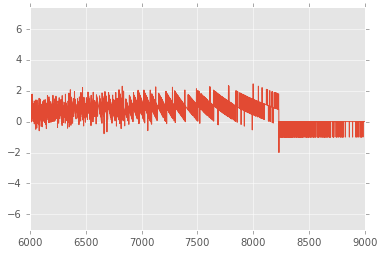

In [541]:
plts(pmtcwf[0, 0], signal_start=6000, signal_end=9000, offset=5)

Not smart to keep adding numbers close to zero!

### Plotting sensor energy

In [25]:
from PandaUtil import *

In [22]:
h5f = tb.open_file('../../data/Waveforms/25ns/WF_Na_test_RWF.h5', "r+")

In [23]:
geom_t = h5f.root.Detector.DetectorGeometry

In [26]:
geom_df = read_data_geom(geom_t)

In [27]:
geom_df

xdet_min   -198.0
xdet_max    198.0
ydet_min   -198.0
ydet_max    198.0
zdet_min      0.0
zdet_max    532.0
R           198.0
dtype: float64

In [28]:
pmt_t = h5f.root.Sensors.DataPMT
sipm_t = h5f.root.Sensors.DataSiPM

In [29]:
pmtdf = read_data_sensors(pmt_t)

In [30]:
sipmdf = read_data_sensors(sipm_t)

In [31]:
pmtdf

,active,adc_to_pes,channel,gain,x,y
0,1,20.0,0,4500000.0,23.9414,65.7785
1,1,20.0,1,4500000.0,-68.9365,-12.1554
2,1,20.0,2,4500000.0,44.9951,-53.6231
3,1,20.0,3,4500000.0,0.0000,185.0000
4,1,20.0,5,4500000.0,-118.9160,141.7180
5,1,20.0,6,4500000.0,-182.1890,32.1249
6,1,20.0,8,4500000.0,-160.2150,-92.5000
7,1,20.0,9,4500000.0,-63.2737,-173.8430
8,1,20.0,10,4500000.0,63.2737,-173.8430
9,1,20.0,12,4500000.0,160.2150,-92.5000


In [32]:
epmt

/RD/epmt (EArray(10, 12), shuffle, blosc(9)) ''
  atom := Int32Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1365, 12)

In [33]:
def plot_ene_pmt(geom_df,sensor_df, epmt, event_number=0, radius=10):
    """
    plots the reconstructed energy of the PMTs
    energy_se is a series describing the reconstructed energy 
    in each PMT
    """
    x =sensor_df['x'].values
    y =sensor_df['y'].values
    r =np.ones(len(sensor_df['x'].values))*radius
    col = epmt[event_number] 
    
    plt.figure(figsize=(10,10))
    ax = plt.subplot(aspect='equal')
    circles(x, y, r, c=col, alpha=0.5, ec='none')
    plt.colorbar()
    #xlim(-198,198)  #one should use geom info
    #ylim(-198,198)
    xlim(geom_df['xdet_min'],geom_df['xdet_max'])
    ylim(geom_df['ydet_min'],geom_df['ydet_max'])
    return col

array([5925, 5976, 5905, 5053, 5061, 5025, 5107, 5100, 5053, 5017, 5089,
       5108], dtype=int32)

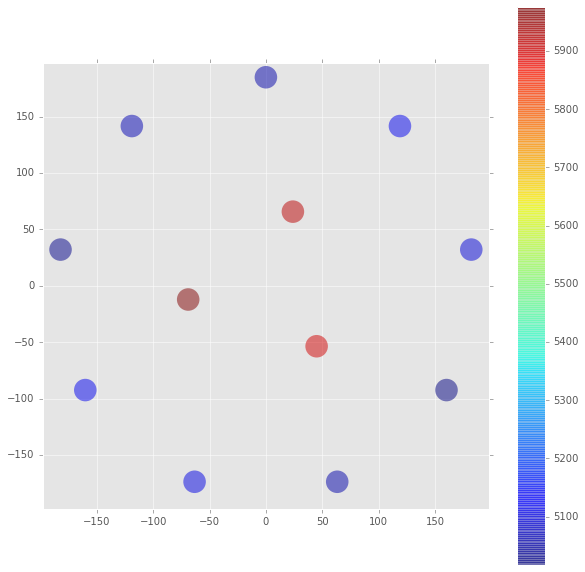

In [34]:
plot_ene_pmt(geom_df,pmtdf, epmt, event_number = 0, radius=10)

array([4475, 4669, 4645, 3970, 3943, 3930, 3896, 4056, 3954, 4064, 3890,
       3958], dtype=int32)

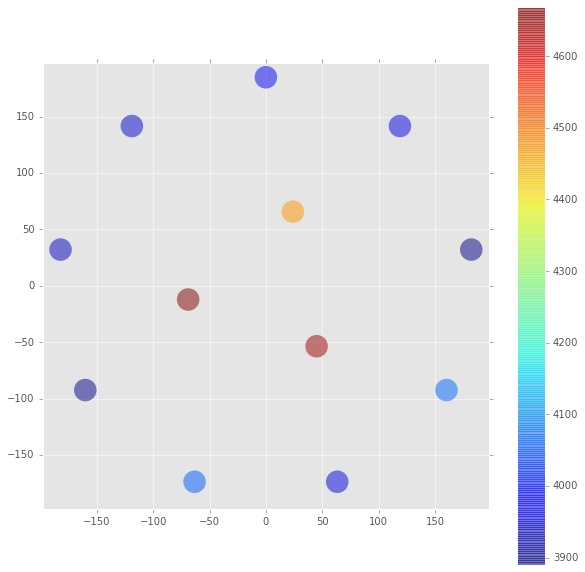

In [35]:
plot_ene_pmt(geom_df,pmtdf, epmt, event_number = 1, radius=10)

array([3762, 3727, 3645, 3232, 3163, 3296, 3210, 3161, 3269, 3073, 3150,
       3155], dtype=int32)

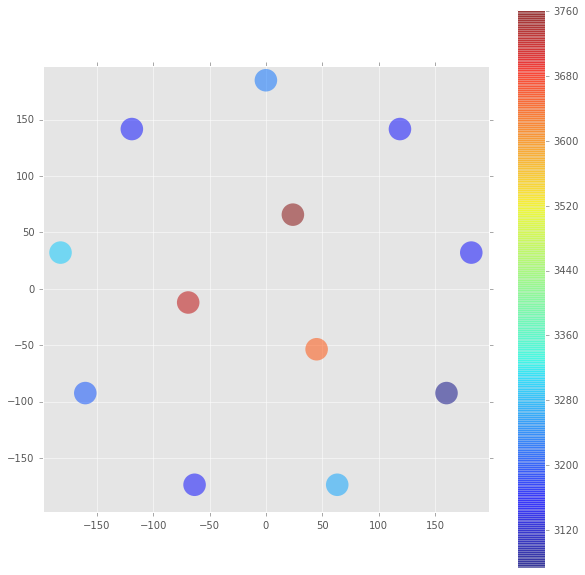

In [37]:
plot_ene_pmt(geom_df,pmtdf, epmt, event_number = 3, radius=10)